#### SANDBOX for code development

In [2]:
#import packages
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import re
import seaborn as sns
from tqdm import tqdm_notebook

#import custom modules
import prep.prep_data as prep
import prep.prep_cv as cv
import model.fuzzy as fz

#magik
%matplotlib inline

In [3]:
#setup globals
#setup directories
CWD = os.getcwd()
HOME_DIR = os.path.abspath(os.path.join(CWD, os.pardir))
DATA_DIR = HOME_DIR + "/data"
DATA_FILENAME = "housing_data.csv"
RESULTS_DIR = HOME_DIR + "/results"

#setup lists of vars to work with
STR_VARS = ['housing_roof', 'housing_wall', 'housing_floor']
NUM_VARS = [s + '_num' for s in STR_VARS]
RANK_VARS = [s + '_rank' for s in STR_VARS]

#which variable do you want to predictn (currently: floor/wall/roof)
PRED_VAR = "housing_roof"
PRED_VAR = PRED_VAR + "_rank" #will always be using the strings to predict ranking

#setup a filter to select which surveys you want to work with
SVY_FILTER = ['MACRO_DHS']

#analytical options
CV_SAMPLE_PCT = .2 #hold out x% for testing
CV_SAMPLE_WT = "N" #which variable, if any, do you want to use to weight your test sample
CV_FOLDS = 3 #use a x-fold cross-validation env

#garbage lists
STR_GARBAGE = ['nan', 'other', 'not a dejure resident', 'not dejure resident']
RANK_GARBAGE = ['4', '5', '6', '7', '8', '9', 'n']

#dictionaries
PRED_DICT = {'natural':'1', 'rudimentary':'2', 'finished':'3'} #map categories back to ranks

In [5]:
df = prep.read_then_clean(DATA_DIR + "/" + DATA_FILENAME, STR_VARS, SVY_FILTER)

~begin reading
data read!
~begin cleaning
data clean!
~applying filter


In [57]:
df_clean = prep.remove_garbage_codes(df, STR_VARS, STR_GARBAGE)
df_clean = prep.extract_ranking(df_clean, NUM_VARS)
df_clean = prep.remove_garbage_codes(df_clean, RANK_VARS, RANK_GARBAGE)
df_clean = df_clean.dropna(subset=[PRED_VAR])
df_one_word = df_clean[base_var].str.get_dummies(sep=' ').T
df_clean['count_word'] = df_one_word.sum()
df_clean = df_clean [df_clean.count_word == 1]
train_list = cv.cv_censor_col(df_clean, PRED_VAR, CV_SAMPLE_PCT, CV_SAMPLE_WT, CV_FOLDS)

{'nan': nan, 'other': nan, 'not a dejure resident': nan, 'not dejure resident': nan}
removing garbage from  housing_roof
removing garbage from  housing_wall
removing garbage from  housing_floor
defining ranking for  housing_roof_num
defining ranking for  housing_wall_num
defining ranking for  housing_floor_num
{'4': nan, '5': nan, '6': nan, '7': nan, '8': nan, '9': nan, 'n': nan}
removing garbage from  housing_roof_rank
removing garbage from  housing_wall_rank
removing garbage from  housing_floor_rank
sampling df, iteration # 0
sampling df, iteration # 1
sampling df, iteration # 2


In [58]:
cv_list = train_list
base_var = 'housing_roof'
rank_dictionary = PRED_DICT

In [60]:
def semantic_similarity_scan(unknown_list, corpus_list):
    
    """This function takes a list of materials for which the rank is unknown (i.e. a word outside our "dictionnary")
    as input and calculates a score of semantic similarity with each word of the list of known material (our "dictionnary").

    Args:
        unknown_list (list of str): This is a list of strings whose rank is unknown
        corpus_list (list of str): This is a list of the strings for which the rank is known. The strings are classified
        within one of three categories of materials.

    Returns:
        distrib (DataFrame): The distribution of the similarity scores between each unknown material in the unknown list and known material
        in the corpus_list.

    """
    
    import pandas as pd
    import numpy as np
    import nltk
    from nltk.corpus import wordnet as wn
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process

    distrib = []

        #loop over each unknown string
    for x in range(len(unknown_list)): 
        unknown_str = unknown_list[x]
        print('analyzing...', unknown_str)
        unknw_syn = wn.synsets(unknown_str)
        out = []
        #loop over each corpus to compute similarity scores for all words in a given housing quality score
        for y in range(len(corpus_list)):
            print('~>corpus#', y)
            corpus = corpus_list[y]


            scores = []
                #loop over each word and compute the similarity score
            for z in range(len(corpus)): #tqdm=progress bar
                list_syn = wn.synsets(corpus[z])
                for s1 in unknw_syn:
                    score = [s1.path_similarity(s2) for s2 in list_syn if s1.path_similarity(s2) is not None]
                scores.append(sum(score))

            out.append(scores) #append scores to create a distribution for the entire corpus

            #append distributions of scores
        distrib.append(pd.DataFrame({'word': unknown_str, 
                                    'natural':pd.Series(out[0]), 
                                    'rudimentary':pd.Series(out[1]), 
                                    'finished':pd.Series(out[2]) #note series method used to overcome differing lengths
                                    }))    
    return(pd.concat(distrib))

In [59]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import model.fuzzy as fz
    
    #setup objects
rank_var = base_var + '_rank'
og_var = rank_var + '_og'
    
    #TODO validate syntax
cv_distrib = []
cv_preds = []
cv_results = []
cv_df = []
    
rank_values = list(rank_dictionary.values())
rank_keys = list(rank_dictionary.keys())

i = 1
df = cv_list[i].copy() #subset the cv list to the current df
#build corpus of known and unknown strings
str_list, idk_strings = fz.build_corpus(df, base_var, rank_var, rank_values)
threshold = 75

building corpus for rank # 1
building corpus for rank # 2
building corpus for rank # 3
extracting unknown strings
need to classify 46 unknown strings


In [63]:
distrib = semantic_similarity_scan(idk_strings[0:5],str_list)

analyzing... metal
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... cement
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... wood
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... tiles
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... cardboard
~>corpus# 0
~>corpus# 1
~>corpus# 2


In [91]:
preds = fz.fuzzy_predict(distrib, rank_keys, 'word', .5,
                                 rank_dictionary)

In [92]:
preds

,natural,rudimentary,finished,pred
word,,,,
cardboard,0.000000,0.006723,0.000000,2
cement,0.036692,0.039669,0.217602,3
metal,0.000000,0.000000,0.605721,3
tiles,0.086967,0.046227,0.921810,3
wood,0.003191,0.020151,0.031233,3


In [96]:
df = cv_list[i].copy()

In [100]:
out[og_var]

0        3
1        3
2        3
3        3
4        3
5        3
6        3
7        3
8        3
9        3
10       3
11       3
12       3
13       3
14       3
15       3
16       3
17       3
18       3
19       3
20       3
21       3
22       3
23       3
24       3
25       3
26       3
27       3
28       3
29       3
        ..
30696    3
30697    3
30698    3
30699    3
30700    3
30701    3
30702    3
30703    3
30704    3
30705    3
30706    3
30707    3
30708    3
30709    3
30710    3
30711    2
30712    3
30713    3
30714    3
30715    3
30716    3
30717    3
30718    3
30719    3
30720    3
30721    3
30722    3
30723    3
30724    3
30725    3
Name: housing_roof_rank_og, Length: 30726, dtype: object

In [98]:
out = df[df['train']==0]
out = pd.merge(out,
                preds,
                left_on=base_var,
                right_on='word',
                how='left')

#calculate success rate and tabulate
out['success'] = np.where(out[og_var] == out['pred'], 1, 0)
success_rate = pd.crosstab(out[~pd.isnull(out['pred'])]['success'], columns='count')
        

In [99]:
success_rate

col_0,count
success,
0,534
1,18933


In [75]:
cv_distrib.append(distrib)
cv_preds.append(preds)
cv_results.append(success_rate)
cv_df.append(out)

In [76]:
preds

,natural,rudimentary,finished,pred
word,,,,
cardboard,0.000000,0.006723,0.000000,2
cement,0.036692,0.039669,0.217602,3
metal,0.000000,0.000000,0.605721,3
tiles,0.086967,0.046227,0.921810,3
wood,0.003191,0.020151,0.031233,3


In [77]:
def fuzzy_density(df, facet, var_list, color_list, variant="", cutoff=None):
    
    #import necessary modules
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    g = sns.FacetGrid(df, col=facet, col_wrap=5, height=3)

    for var in var_list:
        ('plotting...', var)
        g = g.map(sns.kdeplot, var+variant, shade=True, color=color_list[var])
        
        #add cutoff line if provided
        if cutoff != None:
            g = g.map(plt.axvline, x=cutoff, color='grey', linestyle='dashed')
        
    g = g.add_legend()
    
    return(g)

In [84]:
df = cv_distrib
var_list = ['natural', 'rudimentary', 'finished']
color_list = {'natural':'r', 'rudimentary':'b', 'finished':'g'}
cutoff = None
facet = "word"

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

g = sns.FacetGrid(df, col=facet, col_wrap=5, height=3) 

TypeError: list indices must be integers or slices, not str

LinAlgError: singular matrix

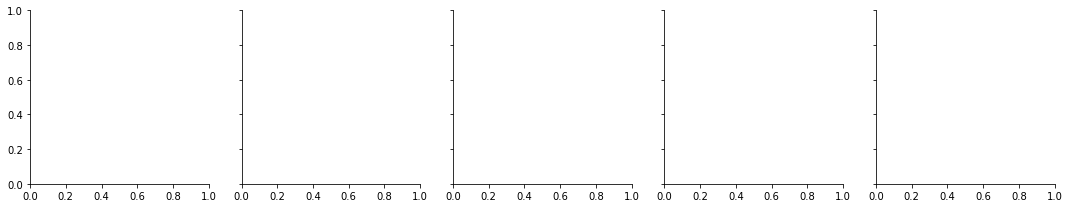

In [89]:
#plot results
fz.fuzzy_density(pd.concat(cv_distrib), 'word', 
                 ['natural', 'rudimentary', 'finished'],
                 color_list={'natural':'r', 'rudimentary':'b', 'finished':'g'})

In [79]:
fz.fuzzy_density(cv_distrib, 'word', 
                 ['natural', 'rudimentary', 'finished'],
                 color_list={'natural':'r', 'rudimentary':'b', 'finished':'g'},
                 cutoff=.5)

TypeError: list indices must be integers or slices, not str

In [131]:
def fuzzy_scan(unknown_list, corpus_list):
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    import nltk
    from nltk.corpus import wordnet as wn
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    from tqdm import tqdm_notebook

    distrib = []

    #loop over each unknown string
    for x in tqdm_notebook(range(len(unknown_list)), desc="classifying unknown strings", leave=False): 
        unknown_str = unknown_list[x]
        print('analyzing...', unknown_str)
        unknwon_str_syn = wn.synsets(unknown_str)
        out = []
        #loop over each corpus to compute similarity scores for all words in a given housing quality score
        for y in range(len(corpus_list)):
            print('~>corpus#', y)
            corpus = corpus_list[y]


            scores = []
            #loop over each word and compute the similarity score
            for z in range(len(corpus)): #tqdm=progress bar
                list_syn = wn.synsets(corpus[z])
                for s1 in unknown_str_syn:
                    score = [s1.path_similarity(s2) for s2 in list_syn if s1.path_similarity(s2) is not None].sum()
                    scores.append(score)
    
        #append distributions of scores
        distrib.append(pd.DataFrame({'word': unknown_str, 
                                     'natural':pd.Series(out[0]), 
                                     'rudimentary':pd.Series(out[1]), 
                                     'finished':pd.Series(out[2]) #note series method used to overcome differing lengths
                                    }))


    return(pd.concat(distrib))


In [ ]:
def fuzzy_cv(cv_list, base_var, rank_dictionary, subset=None, threshold=75):
train_list, 'housing_roof', PRED_DICT
    #import packages
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import pandas as pd
    import numpy as np
    from tqdm import tqdm_notebook

    #import custom modules
    import model.fuzzy as fz
    
    #setup objects
    rank_var = base_var + '_rank'
    og_var = rank_var + '_og'
    
    #TODO validate syntax
    rank_values = list(rank_dictionary.values())
    rank_keys = list(rank_dictionary.keys())
    
    #create lists to store loop outputs
    cv_distrib = []
    cv_preds = []
    cv_results = []
    cv_df = []
    
    #loop over each cross validation:
    for i in tqdm_notebook(range(len(cv_list)), desc="cv loop"):
        
        print('working on cv loop #', i)
        df = cv_list[i].copy() #subset the cv list to the current df

        #build corpus of known and unknown strings
        str_list, idk_strings = fz.build_corpus(df, base_var, rank_var, rank_values)
        
        #subset the unknown strings to allow for faster testing
        if subset != None:
            idk_strings = idk_strings[subset]
        
        #find distribution of scores for each string
        distrib = fz.fuzzy_scan(idk_strings, str_list)
        
        #TODO, output plots of distribution for analysis

        #predict class based on probability of exceeding similarity cutoff
        preds = fz.fuzzy_predict(distrib, rank_keys, 'word', threshold,
                                 rank_dictionary)

        #merge results back on the test data to validate
        out = df[df['train']==0]
        out = pd.merge(out,
                       preds,
                       left_on=base_var,
                       right_on='word',
                       how='left')

        #calculate success rate and tabulate
        out['success'] = np.where(out[og_var] == out['pred'], 1, 0)
        success_rate = pd.crosstab(out[~pd.isnull(out['pred'])]['success'], columns='count')
        
        #append results to prep for next loop
        cv_distrib.append(distrib)
        cv_preds.append(preds)
        cv_results.append(success_rate)
        cv_df.append(out)
        
    return(cv_distrib, cv_preds, cv_results, cv_df)


In [32]:
input_word = "rudimentary bamboo"
d = {}
for x in materials_roof:
    d[x] = is_ci_token_stopword_set_match(input_word, x)

In [36]:
potential_match = []
for x in d:
    if(d[x] == True):
        potential_match.append(x)

In [37]:
potential_match

['bamboo', 'rudimentary palm bamboo']

In [30]:
import nltk.corpus
import nltk.stem.snowball
import string

# Get default English stopwords and extend with punctuation
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')


def is_ci_token_stopword_set_match(a, b, threshold=0.3):
    """Check if a and b are matches."""
    tokens_a = [token.lower().strip(string.punctuation) for token in word_tokenize(a) \
                    if token.lower().strip(string.punctuation) not in stopwords]
    tokens_b = [token.lower().strip(string.punctuation) for token in word_tokenize(b) \
                    if token.lower().strip(string.punctuation) not in stopwords]

    # Calculate Jaccard similarity
    ratio = len(set(tokens_a).intersection(tokens_b)) / float(len(set(tokens_a).union(tokens_b)))
    return (ratio >= threshold)

False

In [16]:
for tok2 in d.values():
    print(tok2)

['nan']
['cardboard', 'cloth', 'tent']
['cement', 'bricks']
['ceramic', 'tiles']
['metal']
['roofing', 'shingles']
['rustic', 'mat', 'mud', 'with', 'hay']
['sod', 'mud', 'with', 'grass']
['thatch', 'bushes', 'grass']
['wood', 'planks']
['wood', 'timber']
['no', 'roof']
['calamine', 'cement', 'fiber']
['cement']
['mud', 'and', 'hay']
['other']
['rustic', 'mat']
['wood']
['grass', 'palm']
['zinc', 'plates']
['concrete', 'slab']
['palm', 'bamboo']
['cardboard']
['tiles']
['reinforced', 'concrete']
['tuale', 'tarred', 'roofing', 'paper']
['thatch', 'palm', 'leaf']
['concrete', 'panels']
['ruberoid', 'asbest']
['slate']
['tol', 'kir']
['adobe']
['metallique']
['tuiles']
['vegetal']
['autre']
['eternit']
['local', 'tiling']
['zinc', 'cement', 'fiber']
['tiles', 'slate']
['sod']
['shingles']
['earth']
['straw']
['tole']
['tuile']
['tile', 'tole']
['leaves']
['tile', 'tuile']
['palm', 'branches']
['tile']
['stone', 'slabs']
['palms', 'bamboo']
['finished', 'roof']
['natural', 'roof']
['rudimen

In [ ]:
def tokenize_vocabulary(vocabulary):
    

In [12]:
# %load most_similar_material.py
def most_similar_material(input_word, vocabulary):

    """This function takes an "unknown"  word (i.e. a word outside our "dictionnary")
    as input and look for the most similar word within a list of words (our "dictionnary").

    Args:
        input_word (str): This is a string whose meaning is ambiguous and therefore needs to be matched with a word
        within our dictionnary.
        vocabulary (list): This is a list of the words included in our vocabulary, i.e we know their rank

    Returns:
        most_similar_word: This function returns the most similar word within our list of words.

    TODO: figure out a way to make this work for short sentences!

    """

    #import packages
    import nltk
    from nltk.corpus import wordnet as wn
    
    # Verify that the input_word is a string
    if type(input_word) is not str:
        class TypeException(Exception):
            """Custom exception class.
            
            This exception is raised when the input word is not a string.

            """
            pass
        
        raise TypeException("The input word is not a string!")
        
    # first, store each word of the vocabulary and its different meanings in a dictionary
    vocabulary_wn = []
    d = {}
    for x in vocabulary:
        vocabulary_wn.append(wn.synsets(x))
        d[x] = wn.synsets(x)

    # then, we define a function returning a key when we call its value
    def getKeysByValue(dictOfElements, valueToFind):
        listOfKeys = list()
        listOfItems = dictOfElements.items()
        for item  in listOfItems:
            if item[1] == valueToFind:
                listOfKeys.append(item[0])
        return  listOfKeys

    # finally, we loop through the different meanings of our new word
    # we compare them to the different meanings of our vocabulary
    s_list = []
    s1 = wn.synsets(input_word)
    maximum = 0
    synonym = None
    for s2 in vocabulary_wn:
        for word1 in s1:
            best = [word1.path_similarity(word2) for word2 in s2 if word1.path_similarity(word2) is not None]
            b = pd.Series(best).max()
            s_list.append(b)
            if max(s_list) > maximum:
                maximum = max(s_list)
                synonym = s2
    
    # We want to make sure we actually found a synonym
    if synonym is None:
        class NoneException(Exception):
            """Custom exception class.
            
            This exception is raised when there is no synonym found.

            """
            pass
        
        raise NoneException("No synonym found for this material")
  
    # We return the word with the closest meaning according to wod2vec
    return(getKeysByValue(d,synonym))


In [25]:
most_similar_material('straw', ["metal","zinc"])

['metal']

In [26]:
most_similar_material('dddeeee', ["metal","zinc"])

NoneException: No synonym found for this material

In [27]:
most_similar_material(15, ["metal","zinc"])

TypeException: The input word is not a string!

In [5]:
df = prep.read_then_clean('../data/housing_data.csv',
                          ['housing_roof', 'housing_wall', 'housing_floor'],
                          ['MACRO_DHS'])

~begin reading
data read!
~begin cleaning
data clean!
~applying filter


In [7]:
materials_roof = df['housing_roof'].unique().tolist()

In [ ]:
df_clean = prep.remove_garbage_codes(df, 
                                     ['housing_roof', 'housing_wall', 'housing_floor'],
                                     ['nan', 'other', 'not a dejure resident', 'not dejure resident'])
df_clean = prep.extract_ranking(df_clean, ['housing_roof_num', 'housing_wall_num', 'housing_floor_num'])
df_clean = prep.remove_garbage_codes(df_clean, 
                                     ['housing_roof_rank', 'housing_wall_rank', 'housing_floor_rank'],
                                     ['4', '5', '6', '7', '8', '9', 'n'])
train_list = cv.cv_censor_col(df_clean, 'housing_roof_rank', .2, 'N', 5)

In [ ]:
cv_distrib, cv_preds, cv_results, cv_df = fuzzy_cv(train_list, 'housing_roof', 
                                                  {'natural':'1', 'rudimentary':'2', 'finished':'3'})

working on cv loop # 0
building corpus for rank # 1
building corpus for rank # 2
building corpus for rank # 3
extracting unknown strings


analyzing... cement bricks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... metal
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... sod mud with grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... thatch bushes grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood planks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood timber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cardboard cloth tent
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... ceramic tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat mud with hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... calamine cement fiber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cement
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... mud and hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... roofing shingles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... no roof
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... zinc plates
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... concrete slab
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... grass palm
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cardboard
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... palm bamboo
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... reinforced concrete
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... tuale tarred roofing paper
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... ruberoid asbest
~>corpus# 0


~>corpus# 1


~>corpus# 2


working on cv loop # 1
building corpus for rank # 1
building corpus for rank # 2
building corpus for rank # 3
extracting unknown strings


analyzing... cement bricks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... ceramic tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... metal
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat mud with hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... sod mud with grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... thatch bushes grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood timber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cardboard cloth tent
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... roofing shingles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood planks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... calamine cement fiber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cement
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... mud and hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... no roof
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... grass palm
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... zinc plates
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... concrete slab
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cardboard
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... palm bamboo
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... reinforced concrete
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... tuale tarred roofing paper
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... concrete panels
~>corpus# 0


~>corpus# 1


~>corpus# 2


working on cv loop # 2
building corpus for rank # 1
building corpus for rank # 2
building corpus for rank # 3
extracting unknown strings


analyzing... cement bricks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... sod mud with grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood timber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... ceramic tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat mud with hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... thatch bushes grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood planks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... metal
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... mud and hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... calamine cement fiber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cement
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... roofing shingles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cardboard cloth tent
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... no roof
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... grass palm
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... zinc plates
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... palm bamboo
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... concrete slab
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... cardboard
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... reinforced concrete
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... tuale tarred roofing paper
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... ruberoid asbest
~>corpus# 0


~>corpus# 1


~>corpus# 2


working on cv loop # 3
building corpus for rank # 1
building corpus for rank # 2
building corpus for rank # 3
extracting unknown strings


analyzing... cement bricks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... rustic mat mud with hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... sod mud with grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood planks
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood timber
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... ceramic tiles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... metal
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... roofing shingles
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... thatch bushes grass
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... mud and hay
~>corpus# 0


~>corpus# 1


~>corpus# 2


analyzing... wood
~>corpus# 0


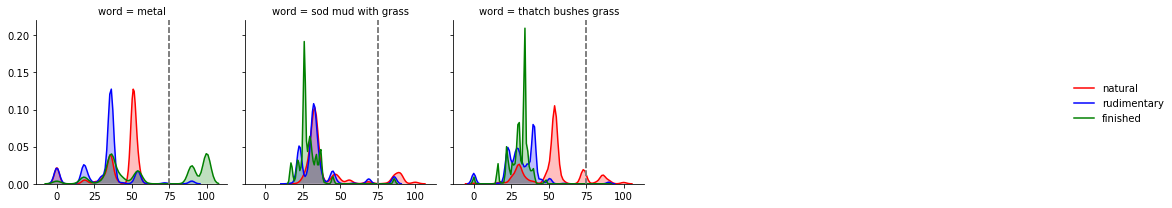

In [20]:
#plot results
fz.fuzzy_density(pd.concat(cv_distrib), 'word', 
                 ['natural', 'rudimentary', 'finished'],
                 color_list={'natural':'r', 'rudimentary':'b', 'finished':'g'},
                 cutoff=75)

In [26]:
#%%file ./model/cv.py

def fuzzy_cv(cv_list, base_var, rank_dictionary, subset=None, threshold=75):

    #import packages
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    import pandas as pd
    import numpy as np
    from tqdm import tqdm_notebook

    #import custom modules
    import model.fuzzy as fz
    
    #setup objects
    rank_var = base_var + '_rank'
    og_var = rank_var + '_og'
    
    #TODO validate syntax
    rank_values = list(rank_dictionary.values())
    rank_keys = list(rank_dictionary.keys())
    
    #create lists to store loop outputs
    cv_distrib = []
    cv_preds = []
    cv_results = []
    cv_df = []
    
    #loop over each cross validation:
    for i in tqdm_notebook(range(len(cv_list)), desc="cv loop"):
        
        print('working on cv loop #', i)
        df = cv_list[i].copy() #subset the cv list to the current df

        #build corpus of known and unknown strings
        str_list, idk_strings = fz.build_corpus(df, base_var, rank_var, rank_values)
        
        #subset the unknown strings to allow for faster testing
        if subset != None:
            idk_strings = idk_strings[subset]
        
        #find distribution of scores for each string
        distrib = fz.fuzzy_scan(idk_strings, str_list)
        
        #TODO, output plots of distribution for analysis

        #predict class based on probability of exceeding similarity cutoff
        preds = fz.fuzzy_predict(distrib, rank_keys, 'word', threshold,
                                 rank_dictionary)

        #merge results back on the test data to validate
        out = df[df['train']==0]
        out = pd.merge(out,
                       preds,
                       left_on=base_var,
                       right_on='word',
                       how='left')

        #calculate success rate and tabulate
        out['success'] = np.where(out[og_var] == out['pred'], 1, 0)
        success_rate = pd.crosstab(out[~pd.isnull(out['pred'])]['success'], columns='count')
        
        #append results to prep for next loop
        cv_distrib.append(distrib)
        cv_preds.append(preds)
        cv_results.append(success_rate)
        cv_df.append(out)
        
    return(cv_distrib, cv_preds, cv_results, cv_df)

In [1]:
%%file ./model/fuzzy.py

#define function to replace meaningless values with NaNs
# def extract_ranking(df, vars_to_clean):
#     """This helper function is used to 

#     Args:
#     df (pandas df): This is a pandas df that has 
#     dep_var (str): This is the name of a column

#     Returns:
#         df_out: 
        
#     TODO: ?

#     """
        
#     df_out = df.copy()

#     #output a clean dataset
#     return 

def build_corpus(df, str_var, rank_var, rank_list):
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    
    out = []
    
    for x in rank_list:
        print("building corpus for rank #", x)
        out.append(df[df[rank_var]==x][str_var].values)    

    print("extracting unknown strings")
    other = df[~df[rank_var].isin(rank_list)][str_var].unique()
    other = other[~pd.isnull(other)] #cant classify NaN
    print("need to classify", len(other), "unknown strings")

    return(out, other)

def fuzzy_scan(unknown_list, corpus_list):
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    from fuzzywuzzy import fuzz
    from fuzzywuzzy import process
    from tqdm import tqdm_notebook

    distrib = []

    #loop over each unknown string
    for x in tqdm_notebook(range(len(unknown_list)), desc="classifying unknown strings", leave=False): 
        unknown_str = unknown_list[x]
        print('analyzing...', unknown_str)

        out = []
        #loop over each corpus to compute similarity scores for all words in a given housing quality score
        for y in range(len(corpus_list)):
            print('~>corpus#', y)
            corpus = corpus_list[y]


            scores = []
            #loop over each word and compute the similarity score
            for z in range(len(corpus)): #tqdm=progress bar
                scores.append(fuzz.WRatio(unknown_str, corpus[z]))

            out.append(scores) #append scores to create a distribution for the entire corpus

        #append distributions of scores
        distrib.append(pd.DataFrame({'word': unknown_str, 
                                     'natural':pd.Series(out[0]), 
                                     'rudimentary':pd.Series(out[1]), 
                                     'finished':pd.Series(out[2]) #note series method used to overcome differing lengths
                                    }))


    return(pd.concat(distrib))

def fuzzy_predict(df, var_list, grouping, cutoff, dictionary):
    
    #calculate the probability that a classification score exceeds cutoff
    out = df.groupby(grouping)[var_list].apply(lambda c: (c>cutoff).sum()/len(c))
    
    #return column w/ max value and map to rank with dictionary
    out['pred'] = out[var_list].idxmax(axis=1).map(dictionary) 
    
    return(out)

def fuzzy_transform(df, var_list, grouping, fx, stub):

    for var in var_list:

        print('calculating prob for...', var)

        kwargs = {var+stub : lambda x: x[var]/x.groupby(grouping)[var].transform(fx)}
        df = df.assign(**kwargs)

    return(df)

def fuzzy_density(df, facet, var_list, color_list, variant="", cutoff=None):
    
    #import necessary modules
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    g = sns.FacetGrid(df, col=facet, col_wrap=5, height=3)

    for var in var_list:
        ('plotting...', var)
        g = g.map(sns.kdeplot, var+variant, shade=True, color=color_list[var])
        
        #add cutoff line if provided
        if cutoff != None:
            g = g.map(plt.axvline, x=cutoff, color='grey', linestyle='dashed')
        
    g = g.add_legend()
    
    return(g)

Overwriting ./model/fuzzy.py


In [ ]:
%%file ./prep/prep_cv.py

#define necessary helper functions
def cv_censor_col(df, colname, pct=.2, weight_var=None, reps=5):
    
    """This function is used to create pandas dfs where a specified % of the values in a column have been censored
    and replaced with NaN, so that they can be predicted in a cross-validation methodology. It returns a list of such
    dfs that is the length of the reps argument.

    Args:
        df (pandas df): This is a pandas df that has columns with garbage values to be removed.
        colname (str): This is a string indicating the name of a column that you want to censor and later predict.
        pct (float): This is a value between 0-1 that indicates the fraction of values you want to censor. Default = 20%
        weight_var (str): This is a string indicating the column name is used to weighted the sample. Default = No weight.
        reps (int): This is an integer indicating the number of different training datasets to create. Default = 5x

    Returns:
        df_clean: This function returns a pandas df where the garbage codes have been replaced with NaN.
        
    TODO: ?

    """
    
    #import packages
    import pandas as pd
    import numpy as np
    
    out = []
    
    for x in range(reps):
            
        print("sampling df, iteration #", x)
    
        #first archive your old column in order to test later
        new_df = df.copy()
        new_df[colname + '_og'] = new_df[colname]
        new_df['train'] = 1 #set column to specify whether training or test data

        #draw a weighted sample if weight var is specified
        if weight_var != None:
            df_censor = new_df.sample(frac=pct, weights=weight_var)
        else:
            df_censor = new_df.sample(frac=pct)
            
        #now replace the sampled column with missing values in order to try and predict
        #note that replacement is only done on the sampled indices
        df_censor['train'] = 0 #note that this sample is no longer training data (it is test)
        df_censor[colname] = "replace_me"
        new_df.update(df_censor, overwrite=True)
        new_df[colname].replace("replace_me", np.nan, inplace=True)
        #TODO unsure if this is pythonic method but it seems like df.update won't replace values with NaN, 
        #as such, need to do this workaround
        
        #store the result (df with columns censored)
        out.append(new_df)
    
    #return the list of sampled dfs
    return(out)

In [ ]:
%%file ./prep/prep_data.py
#define necessary helper functions
def clean_text(text):
    """This function is used to clean a selection of text. 
    It uses several regular expressions and built in text commands in order to remove commonly seen 
    errors,
    nonsense values, 
    punctuation, 
    digits, and 
    extra whitespace.

    Args:
        text (str): This is a text value that needs to be cleaned.

    Returns:
        text: This function returns a cleaned version of the input text.
        
    TODO: Add functionality to impute a selected value for NaN or missing values?

    """
    #import necessary modules
    import re
    
    #force all vals in series to string
    text = str(text)
    
    #first remove uppercase
    text = text.lower()
    
    #remove common errors
    text = re.sub(r"\[.]", "", text) 
    text = re.sub(r"\<ff>", "", text)   
    text = re.sub(r"\<fb>", "", text)
    text = re.sub(r"\<a\d>", "", text)   
    text = re.sub(r"\<c\d>", "", text)   
    text = re.sub(r"\<d\d>", "", text)
    text = re.sub(r"\<e\d>", "", text)   
    text = re.sub(r"\<f\d>", "", text)   
    text = re.sub(r"\d+\.", "", text)

    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)   

    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    # remove any remaining digit codes
    text = re.sub(r"\d+", "", text)
    
    # remove any leading/trailing/duplicate whitespace
    text = re.sub(' +', ' ', text.strip())
    
    return text
    
#define master function
def read_then_clean(file_path, vars_to_clean, filter_series=None):
    """This is the master function for this module. It uses the previously defined helper functions,
    in order to output a clean dataset for user. It reads in a selected .csv file from a given filepath,
    and applies the previously defined cleaning functions to a list of variables provided by user.
    
    It can also optionally filter the df based on the survey series or TODO language.

    Args:
        file_path (str): This is a string indicating which file that you want to read in.
        vars_to_clean (list): This is a list of strings that indicate which columns you want to clean.
        filter_series (list): This is a list of strings that indicate which survey series to keep.

    Returns:
        df_clean: This is a pandas df that has columns of text values that have been cleaned using the helper function.
        
    TODO: Is it better to return an obj called df_clean to be more explicit to user?

    """
    #import necessary modules
    import pandas as pd
    import numpy as np
    
    #read in your data
    print("~begin reading")
    df_raw = pd.read_csv(file_path, low_memory=False)
    min_nrow = len(df_raw) #save the row count to test after cleaning and verify that rows are not being dropped
    print("data read!")
    
    #cleanup
    print("~begin cleaning")
    df_clean = df_raw.copy()
    for var in vars_to_clean:
        df_clean[var] = df_clean[var].apply(clean_text)
    print("data clean!")
    
    # Verify that the minimum rowcount continues to be met
    if len(df_clean) < min_nrow:
        class RowCountException(Exception):
            """Custom exception class.
            
            This exception is raised when the minimum row is unmet.

            """
            pass
        
        raise RowCountException("Minimum number of rows were not returned after cleaning. Data is being lost!")
        
    # Filter data if filter arguments are provided by user
    if filter_series != None:
        print("~applying filter")
        df_clean = df_clean[df_clean['survey_series'].isin(filter_series)]
        
    #output a clean dataset
    return df_clean

#define function to replace meaningless values with NaNs
def remove_garbage_codes(df, vars_to_clean, garbage_list):
    """This helper function is used to remove garbage values from a pandas df, replacing them with NaN.

    Args:
    df (pandas df): This is a pandas df that has columns with garbage values to be removed.
    vars_to_clean (list): This is a list of strings that indicate which columns you want to clean.
    garbage_list (list): This is a list of strings that indicate which garbage values to replace with NaN

    Returns:
        df_clean: This function returns a pandas df where the garbage codes have been replaced with NaN.
        
    TODO: ?

    """
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    
    df_clean = df.copy()
    
    # build dictionary to map all garbage values to NaN
    garb_dict = {}
    for string in garbage_list:
        garb_dict[string] = np.nan
    
    print(garb_dict)
    
    for var in vars_to_clean:
        print("removing garbage from ", var)
        df_clean[var].replace(garb_dict, inplace=True)
        
    #output a clean dataset
    return df_clean

#define function to replace meaningless values with NaNs
def extract_ranking(df, vars_to_clean):
    """This helper function is used to extract the ordinal rankings from numerical coding.

    Args:
    df (pandas df): This is a pandas df that has columns with garbage values to be removed.
    vars_to_rank (list): This is a list of strings that indicate which columns you want to extract ranks from.

    Returns:
        df_out: This function returns a pandas df with new vars added with the ordinal rank cols defined.
        
    TODO: ?

    """
    
    #import necessary modules
    import pandas as pd
    import numpy as np
    import re
    
    df_out = df.copy()
    
    for var in vars_to_clean:
        print("defining ranking for ", var)
        newcol = re.sub("_num", "_rank", var) 
        df_out[newcol] = df_out[var].astype(str).str[0]

    #output a clean dataset
    return df_out

In [ ]:
%%file ./tests/test_prep.py
#write tests
"""This is a module used to test a module: "prep.py" and its relevant functions read_then_clean and clean_text

read_then_clean is a function that takes a csv with messy string values and 
creates then cleans a pandas df
using clean_text

This module tests that function by ensuring that it returns expected exceptions and
does not contain unexpected values.
"""
# import packages
import pytest
import pandas as pd
import re

#import custom modules fpr testing
import prep.prep_data as prep

#set globals for tests
FILEPATH = '../data/housing_data.csv'
CLEAN_COLS = ['housing_roof', 'housing_wall', 'housing_floor']
DIGITS = str([str(x) for x in range(100 + 1)])
PUNCT = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
SPACE = '     '

# if you compile the regex string first, it's even faster
re_dig = re.compile('\d')
re_punct = re.compile('\W+')
re_white = re.compile(' +')

def test_globals():
    """This function tests that the test globals are properly defined.
    """
    #assert that digits are removed
    assert re_dig.search(DIGITS) != None, "global doesn't contain digits!" 
    #assert that punctutation is removed
    assert re_punct.search(PUNCT) != None, "global doesn't contain punctuation!"
    #assert that excessive whitespace is removed
    assert re_white.search(SPACE) != None, "global doesn't contain whitespace!"
    

def test_clean_text():
    """This function tests that the clean text function is doing its job.
    """
    #assert that digits are removed
    assert re_dig.search(prep.clean_text(DIGITS)) == None, "clean_text did not remove the digits from test global." 
    #assert that punctutation is removed
    assert re_punct.search(prep.clean_text(PUNCT)) == None, "clean_text did not remove the punctuation from test global."
    #assert that excessive whitespace is removed
    assert re_white.search(prep.clean_text(SPACE)) == None, "clean_text did not remove the whitespace from test global."

# This is our base dataset and it needs to be cleaned properly. The second argument specifies
# the cols with string values that we want to be cleaned.


#TODO, how to cause read_then_clean to raise the row count exception??
def test_read_then_clean():
    """This function tests that a custom exception called RowCountException
    will be returned when more than 1k rows are expected.
    """
    with pytest.raises(Exception) as err:
        test_df = prep.read_then_clean(FILEPATH,
                                       CLEAN_COLS)
    assert 'RowCountException' in str(err) #verify that your custom error is returned

In [ ]:
#scraps
DIGITS = str([str(x) for x in range(100 + 1)])
PUNCT = "xx"
#PUNCT = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
SPACE = '     '

(DIGITS)
test_globals()
#look at some of the clean values
df_raw.housing_floor.unique().tolist()
clean_text('32. vinyl_asphalt')
print_vars = ['iso3', 'int_year', 'housing_roof', 'housing_roof_rank', 'housing_roof_rank_og', 'train']
obj = train_list[1]
obj[print_vars].sample(50)
#command scraps
#pd.crosstab(train_list[1]['housing_wall_rank'], columns='count')


#fuzzy_scan scraps
distrib = []
match = []

for x in range(len(idk_strings[1:50])): 
    unknown_string = idk_strings[x]
    print('analyzing...', unknown_string)
    
    #set lists to store loop results
    nat = []
    rud = []
    fin = []
               
    for y in range(len(nat_strings)):
        nat.append(fuzz.WRatio(unknown_string, nat_strings[y]))
        rud.append(fuzz.WRatio(unknown_string, rud_strings[y]))
        fin.append(fuzz.WRatio(unknown_string, fin_strings[y]))
    
    #append distributions of scores
    distrib.append(pd.DataFrame({'word': unknown_string, 'natural':nat, 'rudimentary':rud, 'finished':fin}))
    
    #pull best matches
    #note that extractOne returns an array, first item is match/second the ratio
    match.append(pd.DataFrame({'word': unknown_string, 
                               'natural':process.extractOne(unknown_string, nat_strings)[0], 
                               'rudimentary':process.extractOne(unknown_string, rud_strings)[0], 
                               'finished':process.extractOne(unknown_string, fin_strings)[0]}, 
                              index=[0])) 

distrib = pd.concat(distrib)
distrib = fuzzy_transform(distrib, ['natural', 'rudimentary', 'finished'], 'word', 'sum', '_prob')
match = pd.concat(match)

str_list, idk_strings = fz.build_corpus(train_list[1], 'housing_roof', 'housing_roof_rank', ['1', '2', '3'])
distrib = fz.fuzzy_scan(idk_strings, str_list)

In [ ]:
#define test globals
DIGITS = str([str(x) for x in range(100 + 1)])
PUNCT = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
SPACE = '     '

# if you compile the regex string first, it's even faster
re_dig = re.compile('\d')
re_punct = re.compile('\W+')
re_white = re.compile(' +')

def test_globals():
    """This function tests that the test globals are properly defined.
    """
    #assert that digits are removed
    assert re_dig.search(DIGITS) != None, "Global doesn't contain digits!" 
    #assert that punctutation is removed
    assert re_punct.search(PUNCT) != None, "Global doesn't contain punctuation!"
    #assert that excessive whitespace is removed
    assert re_white.search(SPACE) != None, "Global doesn't contain whitespace!"
    

def test_clean_text():
    """This function tests that the clean text function is doing its job.
    """
    #assert that digits are removed
    assert re_dig.search(prep.clean_text(DIGITS)) == None, "clean_text did not remove the digits from test global." 
    #assert that punctutation is removed
    assert re_punct.search(prep.clean_text(PUNCT)) == None, "clean_text did not remove the punctuation from test global."
    #assert that excessive whitespace is removed
    assert re_white.search(prep.clean_text(SPACE)) == None, "clean_text did not remove the whitespace from test global."